In [28]:
import re, os
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from textstat import flesch_reading_ease, flesch_kincaid_grade, gunning_fog
import string
import numpy as np
import pandas as pd
import glob
import time

romanian_chars = "ăîâșțĂÎÂȘȚ" 

### Script to get paragraphs from a markdown file

In [7]:
import re

class RephraserHelper:
    def __init__(
        self,
        number_threshold,
        min_length_threshold,
        max_length_threshold,
        non_normal_chars_threshold,
        normal_chars,
        show_logs,
    ):
        self.number_threshold = number_threshold
        self.min_length_threshold = min_length_threshold
        self.max_length_threshold = max_length_threshold
        self.non_normal_chars_threshold = non_normal_chars_threshold
        self.normal_chars = normal_chars
        self.show_logs = show_logs

    def filter_out(self, to_be_rephrased):
        if self.show_logs:
            print(
                "Length", len(to_be_rephrased), " threshold", self.max_length_threshold
            )
            print(
                "Numbers",
                sum(1 for char in to_be_rephrased if char.isdigit()),
                " threshold",
                self.number_threshold,
            )
            print(
                "Non normal chars",
                sum(1 for char in to_be_rephrased if char not in self.normal_chars),
                " threshold",
                self.non_normal_chars_threshold,
            )
            print(
                "Capital letters ", sum(1 for char in to_be_rephrased if char.isupper())
            )
            print(
                "% of alphabetic chars",
                sum(1 for char in to_be_rephrased if char.isalpha())
                / len(to_be_rephrased),
                " threshold",
                0.75,
            )
        # Avoid division by zero for empty strings
        if not to_be_rephrased:
            return True    
        
        # First letter is capital
        for char in to_be_rephrased:
            if char.isalpha():
                if char.islower():
                    return True
                break
        
        # End with a punctuation
        if to_be_rephrased and to_be_rephrased[-1] not in [".", "!", "?"]:
            return True

        percent_of_alphabetic_chars = sum(
            1 for char in to_be_rephrased if char.isalpha()
        ) / len(to_be_rephrased)
        if percent_of_alphabetic_chars < 0.75:
            return True

        if (
            len(to_be_rephrased) < self.min_length_threshold
            or len(to_be_rephrased) > self.max_length_threshold
        ):
            return True

        if sum(1 for char in to_be_rephrased if char.isdigit()) > self.number_threshold:
            return True

        if (
            sum(1 for char in to_be_rephrased if char not in self.normal_chars)
            > self.non_normal_chars_threshold
        ):
            return True

        if sum(1 for char in to_be_rephrased if char.isupper()) > self.non_normal_chars_threshold:
            return True

        return False

    def get_paragraphs(self, file_path, n_samples):
        with open(file_path, "r", encoding="utf-8") as file:
            text = file.read()

        # Split the text by markdown titles/subtitles
        # The pattern looks for a newline followed by one or more '#' and a space
        # Using positive lookahead (?=...) to split *before* the pattern
        chapters_raw = re.split(r'\n(?=#+ )', text)

        chapter_titles = []
        chapter_contents = []

        for raw_chapter in chapters_raw:
            stripped_chapter = raw_chapter.strip()
            if not stripped_chapter:
                continue

            # Find the first newline to separate title and content
            try:
                newline_index = stripped_chapter.index('\n')
                title_line = stripped_chapter[:newline_index].strip()
                content = stripped_chapter[newline_index:].strip()

                # Clean the title: remove leading '#' and space
                title = re.sub(r'^#+\s*', '', title_line).strip()

            except ValueError:
                # Handle cases where a chapter might only have a title line
                title_line = stripped_chapter
                content = ""
                title = re.sub(r'^#+\s*', '', title_line).strip()

            if title: # Only add if a title was actually found
                chapter_titles.append(title)
                chapter_contents.append(content)

        # for i in range(len(chapter_contents)):
        #     print("Chapter:", i)
        #     print("Title", chapter_titles[i])
        #     print(chapter_contents[i])
        #     print("Length", len(chapter_contents[i]))
        #     print('--'*20)
        
        ans = []
        ans_titles = []
        
        for i, chapter in enumerate(chapter_contents):
            # Cut the chapter content into a smaller chunk if it's too long
            while len(chapter) > self.max_length_threshold:
                # Find the index of the last newline character
                last_newline_index = chapter.rfind('\n')
                if last_newline_index != -1:
                    # Cut the text from the last newline to the end by keeping the part before it
                    chapter = chapter[:last_newline_index].rstrip() # Use rstrip to remove potential trailing whitespace
                else:
                    break
            
            if self.filter_out(chapter):
                if self.show_logs:
                    print("Bad text:\n", chapter)
            else:
                if self.show_logs:
                    print("Good text:\n", chapter)
                ans.append(chapter)
                ans_titles.append(chapter_titles[i])

                if len(ans) == n_samples:
                    break
                
            if self.show_logs:
                print("Current number of samples", len(ans))
        return (ans, ans_titles)  
    

### Parameters for the script

In [4]:
n_samples = 20

min_length_threshold = int(4 * 700)
max_length_threshold = int(4 * 1400)
numbers_threshold = 0.1 * max_length_threshold # max 10% of the text can be numbers
non_normal_chars_threshold = 150

normal_chars = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;:!?-%0123456789[]()" + romanian_chars



helper = RephraserHelper(
    numbers_threshold,
    min_length_threshold,
    max_length_threshold,
    non_normal_chars_threshold,
    normal_chars,
    False
)

### Single use of the script for testing

In [13]:
file = "../mds_marker_0_500_clean/2.md"
samples, titles = helper.get_paragraphs(file, n_samples)
print(len(samples))
for i in range(len(samples)):
    print("Title=", titles[i])
    print(samples[i])
    print('-' * 50)

20
Title= 1. INTRODUCERE
În contextul evoluției rapide a tehnologiei și a schimbărilor continue din mediul de afaceri și din instituții publice, auditul intern deține un rol semnificativ în asigurarea transparenței, integrității și eficienței operaționale a acestora. Cu toate acestea, complexitatea crescută a activităților și volumul tot mai mare de date cu care auditorii trebuie să lucreze. au generat noi provocări și a necesitat adaptarea continuă a metodologiilor și instrumentelor de audit. În acest context, inteligența artificială (IA) a apărut ca o soluție promițătoare pentru a îmbunătăți calitatea procesului de audit intern. Tehnologiile de IA, cum ar fi învățarea automată, analiza avansată a datelor și procesarea limbajului natural, oferă auditorilor instrumente puternice pentru a efectua analize mai profunde, pentru a identifica riscuri și anomalii și pentru a eficientiza procesele de audit. Aceste tehnologii permit automatizarea sarcinilor repetitive, reducerea erorilor umane 

### Batch processing of the script

In [14]:
def process_documents(input_folder, min_length_threshold, max_length_threshold, n_samples, helper):    
    # Generate output filename
    filename = f"../dataframe_{min_length_threshold}-{max_length_threshold}_ch_marker_chapters_{input_folder.split('/')[-1]}.csv"
    if os.path.exists(filename):
        print("File already exists! Added timestamp to the filename.")
        filename = filename + "_" + str(int(time.time())) + ".csv"

    data = []
    document_files = glob.glob(f"{input_folder}/*.md")
    print("Files to process: ", len(document_files))

    processed_count = 0

    for document_file in document_files:
        document_id = document_file.split("/")[-1].split(".")[0]
        print("Processing file: ", document_file)
        
        samples, titles = helper.get_paragraphs(document_file, n_samples)
        
        for i in range(len(samples)):
            data.append({"document_id": document_id, "sample": samples[i], "title": titles[i]})

        processed_count += 1
        print("Processed file: ", document_file)


    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print("Final data saved to " + filename)
    
    return filename

In [15]:
output_file = process_documents("../mds_marker_0_500_clean", min_length_threshold, max_length_threshold, n_samples, helper)

Files to process:  367
Processing file:  ../mds_marker_0_500_clean/423.md
Processed file:  ../mds_marker_0_500_clean/423.md
Processing file:  ../mds_marker_0_500_clean/186.md
Processed file:  ../mds_marker_0_500_clean/186.md
Processing file:  ../mds_marker_0_500_clean/348.md
Processed file:  ../mds_marker_0_500_clean/348.md
Processing file:  ../mds_marker_0_500_clean/421.md
Processed file:  ../mds_marker_0_500_clean/421.md
Processing file:  ../mds_marker_0_500_clean/468.md
Processed file:  ../mds_marker_0_500_clean/468.md
Processing file:  ../mds_marker_0_500_clean/293.md
Processed file:  ../mds_marker_0_500_clean/293.md
Processing file:  ../mds_marker_0_500_clean/71.md
Processed file:  ../mds_marker_0_500_clean/71.md
Processing file:  ../mds_marker_0_500_clean/64.md
Processed file:  ../mds_marker_0_500_clean/64.md
Processing file:  ../mds_marker_0_500_clean/152.md
Processed file:  ../mds_marker_0_500_clean/152.md
Processing file:  ../mds_marker_0_500_clean/376.md
Processed file:  ../m

### Look into the dataframe

In [16]:
df = pd.read_csv(output_file)
df.head()

#### Print chapters for a single document_id

In [26]:
target_document_id = 2
target_rows = df[df['document_id'] == int(target_document_id)]
for _, row in target_rows.iterrows():
    print("Title=", row['title'])
    print(row['sample'])
    print('=' * 150)

Title= 1. INTRODUCERE
În contextul evoluției rapide a tehnologiei și a schimbărilor continue din mediul de afaceri și din instituții publice, auditul intern deține un rol semnificativ în asigurarea transparenței, integrității și eficienței operaționale a acestora. Cu toate acestea, complexitatea crescută a activităților și volumul tot mai mare de date cu care auditorii trebuie să lucreze. au generat noi provocări și a necesitat adaptarea continuă a metodologiilor și instrumentelor de audit. În acest context, inteligența artificială (IA) a apărut ca o soluție promițătoare pentru a îmbunătăți calitatea procesului de audit intern. Tehnologiile de IA, cum ar fi învățarea automată, analiza avansată a datelor și procesarea limbajului natural, oferă auditorilor instrumente puternice pentru a efectua analize mai profunde, pentru a identifica riscuri și anomalii și pentru a eficientiza procesele de audit. Aceste tehnologii permit automatizarea sarcinilor repetitive, reducerea erorilor umane și 

#### Print random paragraphs from the dataframe

In [27]:
import random

print(len(df))
num_paragraphs_to_print = 25  # You can adjust this number
random_indices = random.sample(range(len(df)), min(num_paragraphs_to_print, len(df)))

print("Random paragraphs from the dataframe:")
for index in random_indices:
    print(f"Index: {index}")
    print(f"Document ID: {df['document_id'][index]}")
    text = df["sample"][index]
    print(f"length: {len(df['sample'][index])}")
    print("Length", len(text), " threshold", max_length_threshold)
    print(
        "Numbers",
        sum(1 for char in text if char.isdigit()),
        " threshold",
        numbers_threshold,
    )
    print(
        "Non normal chars",
        sum(1 for char in text if char not in normal_chars),
        " threshold",
        non_normal_chars_threshold,
    )
    print("Capital letters ", sum(1 for char in text if char.isupper()))
    print(
        "% of alphabetic chars",
        sum(1 for char in text if char.isalpha()) / len(text),
        " threshold",
        0.75,
    )
    print('=' * 50)
    print("title =", df["title"][index])
    print('=' * 50)
    print(text)
    print("-" * 50)

5634
Random paragraphs from the dataframe:
Index: 1875
Document ID: 261
length: 4287
Length 4287  threshold 5600
Numbers 27  threshold 560.0
Non normal chars 39  threshold 150
Capital letters  117
% of alphabetic chars 0.8147888966643341  threshold 0.75
title = 2.1. TOPOLOGII ȘI STANDARDE
Consumul de energie electrică al unui Centru de Date este de 10-40 ori mai mare decât în clădirile office. Consumatorii specifici sunt cei de tip IT (servere, rețele de comunicații, data storage) și cei referitori la infrastructură (iluminat, UPS, condiționare putere, aer condiționat/instalații de răcire a serverelor). In Fig.2.1 se indică repartiția tip a consumului de energie la un Centru de Date.

Sursele de energie electrică la un Centru de Date sunt reprezentate de cele 2 linii trifazate de joasă tensiune racordate la rețeaua m.t sau î.t. de energie electrică, generatoarele și sursele UPS și rețelele proprii de energie regenerabilă.

Utilizarea echipamentelor cu alimentară duală reprezintă o prac

#### list of bad docs
1. 15059
2. 13896
3. 11295
4. 14429
5. 

### Code to create the dataframes used to generate text for each model

In [ ]:
# split a dataframe into two egal smaller dataframes with odd indexes into one and even indexes into the other
def split_dataframe(df):
    # iloc slicing preserves the original index
    df1 = df.iloc[::2]
    df2 = df.iloc[1::2]
    return df1, df2

filename =output_file
df1, df2 = split_dataframe(df)

# Save the dataframes to CSV, including the original index as a column
df1.to_csv(filename.replace(".csv", "_GEMINI.csv"), index=True, index_label='original_index')
df2.to_csv(filename.replace(".csv", "_CHATGPT.csv"), index=True, index_label='original_index')

In [5]:
print(len(df1))
df1.head()


46675


,document_id,sample,title
0,10589,În cadrul programului de cercetare dezvoltat s...,PREFAȚĂ
2,10589,Deșeul reprezintă partea dintr-un material sau...,2.1 Noțiuni de bază
4,10589,În urma diferitelor etape de flux tehnologic d...,3.2 Prezentarea generală a caracteristicilor c...
6,10589,"În secolul XX, în mod deosebit în a doua jumăt...",3.2.1.7 Zgură de oțelărie
8,10589,Peletizarea minereurilor de fier este cunoscut...,4.2.1 Producerea peletelor


In [6]:
print(len(df1)) 
df2.head()

46675


,document_id,sample,title
1,10589,Tema tezei de doctorat este de actualitate și ...,1.1 Descrierea esențializată a obiectului cerc...
3,10589,Prin deșeuri industriale nerecuperabile se înț...,2.3 Reciclarea deșeurilor industriale nerecupe...
5,10589,Principalele surse de generare a țunderului pe...,3.2.1.6 Țunderul
7,10589,Cenușile piritice au rezultat de la fabricile ...,3.3.3 Cenuși piritice (industria chimică)
9,10589,Ținând seama de solicitările la care sunt supu...,4.2.3 Calitatea peletelor utilizate în încărcă...


# Paragraphs analysis


In [33]:
filename= "../dataframe_2800-5600_ch_marker_chapters_mds_marker_0_500_clean.csv"
df = pd.read_csv(filename)
df.head()

,document_id,sample,title
0,423,Apa este o resursă naturală extrem de abundent...,1.1. Starea actuală a amenajărilor hidrotehnic...
1,423,Energia hidroelectrică reprezintă 67% din capa...,1.1.1. Situația actuală pe plan internațional ...
2,423,"Din totalul de energie electrică generată, 31%...",Turcia
3,423,25 Hidroenergia în Egipt reprezintă 22% din en...,Egipt
4,423,România este cunoscută la nivel global ca o ța...,1.1.2 Situația actuală la nivel național a bar...


In [30]:
# the average of paragraphs per document
print(df.groupby("document_id").count().mean())
print(len(df))

sample    15.393443
title     15.393443
dtype: float64
5634


In [31]:
# the average of characters per paragraph
print(df["sample"].apply(len).mean())


4392.326233581824


[nltk_data] Downloading package punkt to /home/ionut/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ionut/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1. Paragraph Length:
   - Average number of characters per paragraph: 4392.326233581824
   - Average number of words per paragraph: 720.9455094071708


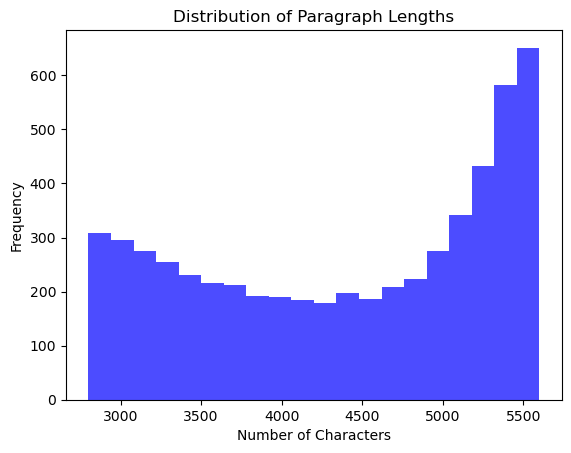


2. Word Statistics:
   - Average word length: 7.438247543250657
   - Frequency of unique words: 120701
   - Most common words: [('și', 118999), ('the', 6856), ('între', 6199), ('et', 5900), ('mare', 5213), ('precum', 4940), ('timp', 4813), ('of', 4723), ('fiind', 4617), ('nivelul', 3806)]

3. Sentence Statistics:
   - Average number of sentences per paragraph: 24.029108981185658
   - Average sentence length (in words): 30.00530358989511

4. Lexical Diversity:
   - Type-token ratio: 0.029716084491459096

5. Readability Metrics:
   - Average Flesch Reading Ease score: 31.25146077387291

6. Special Character Usage:
   - Frequency of punctuation marks: 636680
   - Frequency of non-alphanumeric characters: 646132

7. Language-Specific Features:
   - Frequency of Romanian diacritics: 1072635

8. Thematic Analysis:
   - Keyword frequency: [('și', 118999), ('the', 6856), ('între', 6199), ('et', 5900), ('mare', 5213), ('precum', 4940), ('timp', 4813), ('of', 4723), ('fiind', 4617), ('nivelul',

In [32]:
# Ensure NLTK resources are downloaded
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Data preparation
paragraphs = df["sample"].tolist()
stop_words = set(stopwords.words('romanian'))

# 1. Paragraph Length
avg_chars_per_paragraph = np.mean([len(p) for p in paragraphs])
avg_words_per_paragraph = np.mean([len(word_tokenize(p)) for p in paragraphs])
paragraph_lengths = [len(p) for p in paragraphs]

print("1. Paragraph Length:")
print(f"   - Average number of characters per paragraph: {avg_chars_per_paragraph}")
print(f"   - Average number of words per paragraph: {avg_words_per_paragraph}")

plt.hist(paragraph_lengths, bins=20, color='blue', alpha=0.7)
plt.title("Distribution of Paragraph Lengths")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()

# 2. Word Statistics
all_words = [word.lower() for p in paragraphs for word in word_tokenize(p)]
filtered_words = [word for word in all_words if word not in stop_words and word.isalnum()]
avg_word_length = np.mean([len(word) for word in filtered_words])
unique_word_freq = Counter(filtered_words)
most_common_words = unique_word_freq.most_common(10)

print("\n2. Word Statistics:")
print(f"   - Average word length: {avg_word_length}")
print(f"   - Frequency of unique words: {len(unique_word_freq)}")
print(f"   - Most common words: {most_common_words}")

# 3. Sentence Statistics
avg_sentences_per_paragraph = np.mean([len(sent_tokenize(p)) for p in paragraphs])
avg_sentence_length = np.mean([len(word_tokenize(sent)) for p in paragraphs for sent in sent_tokenize(p)])

print("\n3. Sentence Statistics:")
print(f"   - Average number of sentences per paragraph: {avg_sentences_per_paragraph}")
print(f"   - Average sentence length (in words): {avg_sentence_length}")

# 4. Lexical Diversity
type_token_ratio = len(unique_word_freq) / len(all_words)
print("\n4. Lexical Diversity:")
print(f"   - Type-token ratio: {type_token_ratio}")

# 5. Readability Metrics
readability_scores = [flesch_reading_ease(p) for p in paragraphs]
avg_readability = np.mean(readability_scores)

print("\n5. Readability Metrics:")
print(f"   - Average Flesch Reading Ease score: {avg_readability}")

# 6. Special Character Usage
punctuation_freq = sum([1 for char in ''.join(paragraphs) if char in string.punctuation])
non_alphanumeric_freq = sum([1 for char in ''.join(paragraphs) if not char.isalnum() and char not in string.whitespace])

print("\n6. Special Character Usage:")
print(f"   - Frequency of punctuation marks: {punctuation_freq}")
print(f"   - Frequency of non-alphanumeric characters: {non_alphanumeric_freq}")

# 7. Language-Specific Features
romanian_char_freq = sum([1 for char in ''.join(paragraphs) if char in romanian_chars])

print("\n7. Language-Specific Features:")
print(f"   - Frequency of Romanian diacritics: {romanian_char_freq}")

# 8. Thematic Analysis
keyword_freq = Counter(filtered_words).most_common(10)
print("\n8. Thematic Analysis:")
print(f"   - Keyword frequency: {keyword_freq}")

# 9. Document-Level Statistics
paragraphs_per_document = df.groupby("document_id").size()
avg_paragraphs_per_document = paragraphs_per_document.mean()

print("\n9. Document-Level Statistics:")
print(f"   - Average number of paragraphs per document: {avg_paragraphs_per_document}")

# 10. Outlier Detection
too_short = [p for p in paragraphs if len(p) < min_length_threshold]
too_long = [p for p in paragraphs if len(p) > max_length_threshold]

print("\n10. Outlier Detection:")
print(f"   - Number of too short paragraphs: {len(too_short)}")
print(f"   - Number of too long paragraphs: {len(too_long)}")

In [ ]:
# range of tokens :> 1100 - 1200 - 1300


11. Token Approximation:
   - Average estimated tokens per paragraph: 1057.5847875781753


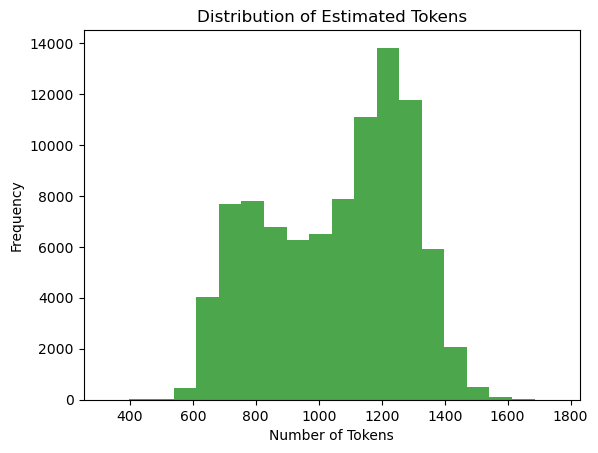

In [20]:
average_tokens_per_word = 1.4  # Adjust this based on your LLM and language

paragraphs = df["sample"].tolist()
estimated_tokens = [len(word_tokenize(p)) * average_tokens_per_word for p in paragraphs]
avg_estimated_tokens = np.mean(estimated_tokens)

print("\n11. Token Approximation:")
print(f"   - Average estimated tokens per paragraph: {avg_estimated_tokens}")

plt.hist(estimated_tokens, bins=20, color='green', alpha=0.7)
plt.title("Distribution of Estimated Tokens")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

# old code

In [ ]:
        # ans = []
        # to_be_rephrased = ""
        # for i in range(len(paragraphs)):
        #     current_paragraph = paragraphs[i]
        #     temp_rephrased = to_be_rephrased + "\n\n" + current_paragraph

        #     if len(temp_rephrased) > self.max_length_threshold:
        #         paragraphs_split = temp_rephrased.split("\n\n")

        #         while (
        #             len("\n\n".join(paragraphs_split)) > self.max_length_threshold
        #             and len(paragraphs_split) > 1
        #         ):
        #             paragraphs_split.pop(0)

        #         temp_rephrased = "\n\n".join(paragraphs_split)

        #     if self.filter_out(temp_rephrased):
        #         to_be_rephrased = temp_rephrased
        #         if self.show_logs:
        #             print("Bad text:\n", temp_rephrased)
        #     else:
        #         if self.show_logs:
        #             print("Good text:\n", temp_rephrased)
        #         ans.append(temp_rephrased)
        #         to_be_rephrased = ""

        #         if len(ans) == n_samples:
        #             break

        #     # print("Finished iteration", i)
        #     # print("Current number of samples", len(ans))
        #     # print("Current sample size", len(to_be_rephrased))
        #     # print("Current paragraph size", len(current_paragraph))
        #     # print("Current paragraph", current_paragraph)
        #     # print("to be rephrased", to_be_rephrased)
        # return ans

In [ ]:
# file_path = "../mds_clean_only_ro/12541.md"
# samples = helper.get_paragraphs(file_path, n_paragraphs, n_samples)

# for sample in samples:
#     print(sample)
#     print('1')

In [ ]:
# txt = "În realizarea acestui deziderat este absolut necesar ca deciziile să fie luate pe baza unor parametri obiectivi, care să fie comparabili şi să poată fi urmăriți în evoluție, și care să reflecte starea pacientului; din acest punct de vedere, există puține elemente clinice cu caracter de obiectivitate, și acestea s-au dovedit a nu fi eficiente în ghidarea tratamentului sau în predicția apariției unor complicații. Din aceste considerente, prezenta cercetare doctorală a analizat o categorie de parametri care îndeplinesc criteriile menționate anterior, și anume parametrii biochimici, care pot cuantifica nu numai impactul leziunilor inițiale, dar și pe cel al gesturilor terapeutice prin prisma capacității lor de a reflecta intensitatea inflamației și a celorlalte fenomene patologice din politraumă, întrucât acestea se desfasoară la nivel celular, prin intermediul unor mediatori."
# print(normal_chars)
# for i in txt:
#     if i not in normal_chars:
#         print(i)
        
# sum(
#     1
#     for char in txt
#     if char not in normal_chars
# )

In [ ]:
# import random
# from nltk.tokenize import sent_tokenize

# class RephraserHelper:
#     def __init__(self, rephraser, number_threshold, length_threshold, sentences_threshold, n_sentences):
#         self.rephraser = rephraser
#         self.number_threshold = number_threshold
#         self.length_threshold = length_threshold
#         self.sentences_threshold = sentences_threshold
#         self.n_sentences = n_sentences

#     def filter_out(self, to_be_rephrased): 
#         # If the text is too short, don't rephrase
#         if len(to_be_rephrased) < self.length_threshold:
#             return True
        
#         # If the text contains a lot of numbers, don't rephrase
#         if sum(1 for char in to_be_rephrased if char.isdigit()) > self.number_threshold:
#             print("Numbers", sum(1 for char in to_be_rephrased if char.isdigit()))
#             return True
        
#         return False

#     def reprphrase(self, file_path, n_times):
#         with open(file_path, "r", encoding="utf-8") as file:
#             text = file.read()
            
#         sentences = sent_tokenize(text)
        
#         # If the text is too short, don't rephrase
#         if len(sentences) < self.sentences_threshold:
#             return 
        
#         cnt = 0
#         for _ in range(n_times):
#             start = random.randint(0, len(sentences) - self.n_sentences)
            
#             to_be_rephrased = " ".join(sentences[start : start + self.n_sentences])

#             if self.filter_out(to_be_rephrased):
#                 print("Bad text:", to_be_rephrased)
#                 continue
            
#             reprased_part = self.rephraser.reprase(text, to_be_rephrased)
#             # print(reprased_part)
#             # reprased_text = text.replace(to_be_rephrased, reprased_part)
            
#             ans_text = "Original text: " + to_be_rephrased + "\nRephrased text: " + reprased_part
            
#             # with open(file_path[:-3] + "_sample_.txt", 'a', encoding='utf-8') as file:
#             #     file.write(ans_text + "\n\n")
            
#             print(ans_text)
#             cnt += 1
